In [1]:
import pandas as pd
import requests
import datetime
import json
import lxml

## Looking at one years worth of data (1976)

In [2]:
list_of_dates = list(pd.date_range(start='1/5/1976', end='12/31/2017'))

In [3]:
def get_crossword_data(date):
    try:
        f = open(f'nyt_crosswords-master/{date.year}/{date.month:02}/{date.day:02}.json','r')
        data = json.loads(f.read())
        filled_letters = data['answers']['across']
        length = sum(len(s) for s in filled_letters)
        answers = data['answers']['across'] + data['answers']['down']
        clues = data['clues']['across'] + data['clues']['down']
        author = data['author'] 
        cols = data['size']['cols']
        rows = data['size']['rows']
        editor = data['editor']
        return pd.Series({'answers': answers, 'clues': clues, 'editor':editor, 'author': author, 'size' : rows * cols, 'length' : length})
    except:
        return pd.Series({'answers': [], 'clues': [], 'editor':'', 'author': '', 'size' : 0, 'length' : 0})


In [4]:
df = pd.DataFrame({
    'crossword_date': list_of_dates
})

results = df.crossword_date.apply(get_crossword_data)
df = df.join(results)

df['density'] = df['length']/df['size']
df

,crossword_date,answers,clues,editor,author,size,length,density
0,1976-01-05,"[AJAX, WHOOP, CRAB, BALI, HEAVE, HAME, ADMIRAL...","[1. Greek hero, 5. Loud cry, 10. Peevish perso...",Will Weng,Herb L. Risteen,225,187,0.831111
1,1976-01-06,"[ACTS, GRAB, SHAM, BEAT, GRETA, TONE, ABRA, LA...","[1. Bible book, 5. Seize, 9. Counterfeit, 13. ...",Will Weng,DeWitt Anderson,225,187,0.831111
2,1976-01-07,"[ITA, TILO, CACHE, SNOB, ODOR, ATHOS, OARS, GO...","[1. Give ___ whirl, 4. Linden tree, in Spain, ...",Will Weng,Miller,225,187,0.831111
3,1976-01-08,"[BOMA, ACME, LIEGE, ORES, COATHANGER, WISHFULT...","[1. African stockade, 5. Utmost degree, 9. Feu...",Will Weng,Frank Geary,225,189,0.840000
4,1976-01-09,"[PROS, ARC, FBI, POLES, PULP, IRON, STERE, SEA...","[1. Golf-tour players, 5. Curve part, 8. Govt....",Will Weng,Brian G. Tyler,225,179,0.795556
...,...,...,...,...,...,...,...,...
15332,2017-12-27,[],[],,,0,0,NaN
15333,2017-12-28,[],[],,,0,0,NaN
15334,2017-12-29,[],[],,,0,0,NaN
15335,2017-12-30,[],[],,,0,0,NaN


In [5]:
df = df.dropna()
df_answers_clues = df.set_index('crossword_date').apply(pd.Series.explode).reset_index()
#sparse_array
df_answers_clues[['code','clues']] = df_answers_clues['clues'].str.split(".", 1, expand=True)
df_answers_clues['day_of_week'] = df_answers_clues.crossword_date.dt.day_name()

In [6]:
GridSize_df = pd.pivot_table(df_answers_clues,
                        values=['size'],
                        columns=['day_of_week'],
                        fill_value=0,
                        aggfunc='describe').reindex(dayOrder,axis=1)
GridSize_df

NameError: name 'dayOrder' is not defined

### Adding the length of each word

In [44]:
df_answers_clues['answer_length'] = df_answers_clues['answers'].str.len()

#### Plotting the distribution of the lengths of the words

<AxesSubplot:>

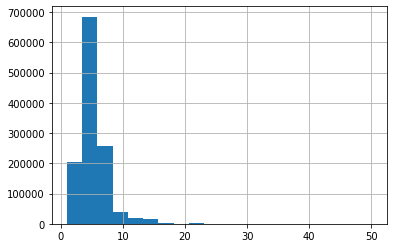

In [54]:
df_answers_clues.answer_length.hist(bins = 20)

#### What are the length distributions according to the day of the week?

In [43]:
#Longest words are found in the Sunday paper 
df_answers_clues[df_answers_clues.answer_length > 15].sort_values('answer_length', ascending = False)['day_of_week'].value_counts()

Sunday       3233
Thursday      107
Friday         29
Tuesday        21
Saturday       19
Wednesday      14
Monday          9
Name: day_of_week, dtype: int64

In [180]:
df_answers_clues['crossword_year'] = df_answers_clues['crossword_date'].dt.year
df_answers_clues[['crossword_date', 'answers', 'clues', 'crossword_year']].to_csv('slangtill2015.csv')

In [ ]:
dayOrder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Pivotdf = pd.pivot_table(df_answers_clues,
                        values=['density'],
                        columns=['day_of_week'],
#                         fill_value=0,
                        aggfunc='mean').reindex(dayOrder,axis=1)
Pivotdf

In [ ]:
df_answers_clues.groupby(['day_of_week']).describe().answer_length

#### Number of unique answers for each day in the week

In [ ]:
unique_words = df_answers_clues[df_answers_clues['answers'].map(df_answers_clues['answers'].value_counts()) == 1]
unique_words.groupby('day_of_week').count()

dayOrder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pd.pivot_table(unique_words,
                values=['answers'],
                columns=['day_of_week'],
                fill_value=0,
                aggfunc='count').reindex(dayOrder,axis=1)


#### What is the most common word?

In [ ]:
answer_count = df_answers_clues['answers'].value_counts().head(1)
answer_count

#### What is the most common word for different word lengths?

In [ ]:
df_answers_clues.groupby(["answer_length", "answers"])["answers"].value_counts(ascending=False).groupby(level=0, group_keys=False).nlargest(1).to_frame()

In [ ]:
df_answers_clues['answers'].value_counts().head(5)


#### Lets look at the clues

In [ ]:
# df_answers_clues[df_answers_clues['clues'].str.contains("?", regex=False) == True]
df_answers_clues[df_answers_clues['clues'].str.contains("subtly", regex=False) == True]

In [ ]:
df_answers_clues[df_answers_clues['clues'].str.contains("?", regex=False) == True].crossword_year.hist()

In [ ]:
df_answers_clues[df_answers_clues['answers'].str.contains('YOGA', regex=False) == True].crossword_year.hist()


In [ ]:
non_MASH = df_answers_clues[df_answers_clues['clues'].str.contains("M*A*S*H", regex=False) == False]
non_MASH[non_MASH['clues'].str.contains("*", regex=False) == True].crossword_year.hist()

In [ ]:
print(df_answers_clues[df_answers_clues['clues'].str.contains('informally', regex=False) == True].clues.unique())
df_answers_clues[df_answers_clues['clues'].str.contains('informally', regex=False) == True].crossword_year.hist()


In [ ]:
df_answers_clues[df_answers_clues['clues'].str.contains('girl') & df_answers_clues['clues'].str.contains('?', regex=False)].head(55)

In [ ]:
df_answers_clues[df_answers_clues['clues'].str.contains('Wall St')].tail(55)

In [ ]:
df_answers_clues[(df_answers_clues['clues'].str.contains('colloquial'))].head()

In [96]:
slang = df_answers_clues[df_answers_clues['clues'].str.contains('colloquially', regex=False) |df_answers_clues['clues'].str.contains('modern lingo', regex=False) | df_answers_clues['clues'].str.contains('slang', regex=False) | df_answers_clues['clues'].str.contains('informally', regex=False) | df_answers_clues['clues'].str.contains('slangily', regex=False)]
slang.answers.drop_duplicates().to_csv("slang_unique_list.csv")
#AMMO, RAP, PICS

<AxesSubplot:>

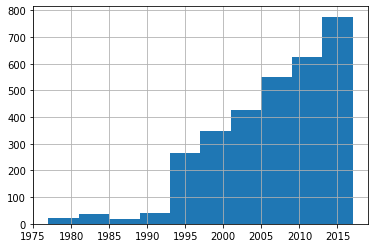

In [42]:
df_answers_clues[df_answers_clues['clues'].str.contains('colloquially', regex=False) |df_answers_clues['clues'].str.contains('modern lingo', regex=False) | df_answers_clues['clues'].str.contains('slang', regex=False) | df_answers_clues['clues'].str.contains('informally', regex=False) | df_answers_clues['clues'].str.contains('slangily', regex=False)]['crossword_year'].hist()

In [178]:
df_answers_clues[df_answers_clues['clues'].str.contains('emoji', regex=False)].tail(50)

,crossword_date,answers,clues,editor,author,size,length,density,code,day_of_week,answer_length,crossword_year
1178484,2014-06-22,TEXT,"Message with an emoji, maybe",Will Shortz,Elizabeth C. Gorski,441,370,0.839002,18,Sunday,4,2014
1217807,2016-07-12,TEXT,It might contain an emoji,Will Shortz,Samuel A. Donaldson,225,191,0.848889,13,Tuesday,4,2016


In [ ]:
df_answers_clues[df_answers_clues['clues'].str.contains('!', regex=False) == True][['answers', 'clues']].drop_duplicates()

In [174]:
# REUP, GMAN
# OVER TIME: ALLERGY, BAGS, 
# person represents another meaning: ABES:FIVER, BAILS. 
frequent_answers= df_answers_clues[df_answers_clues['answers'] == 'SHTUP']
unique_clues = frequent_answers[['answers','clues','crossword_year']].sort_values(['crossword_year']).drop_duplicates()
unique_clues.head(50)

,answers,clues,crossword_year
1176457,SHTUP,"Sleep with, in slang",2014


In [ ]:
unique_clues

In [177]:
# DUDE, RAD, INSANE, COOL, GNARLY,DIS, COMP, SLAPS
frequent_answers= df_answers_clues[df_answers_clues['answers'] == 'EMOJI']
unique_clues = frequent_answers[['answers','clues','crossword_year']].sort_values(['crossword_year']).drop_duplicates()
unique_clues.head(50)

,answers,clues,crossword_year
1183174,EMOJI,What you might use to put on a happy face?,2014
1221712,EMOJI,"Symbol like ""prayer hands"" or ""heart eyes""",2016


In [ ]:
frequent_answers= df_answers_clues[df_answers_clues['answers'] == 'GAY']
unique_clues = frequent_answers[['answers','clues','crossword_year']].sort_values(['crossword_year']).drop_duplicates()
unique_clues

In [ ]:
unique_clues.clues.drop_duplicates()

#### Who are the people behind the crosswords

In [ ]:
df_answers_clues.groupby('editor').count()

In [ ]:
authors = df_answers_clues[['author', 'answers', 'crossword_date']].groupby(['author', 'answers']).count().reset_index()
authors[authors['crossword_date'] > 6].sort_values(by = ['author', 'crossword_date'], ascending = [True, False]).head(60)

In [ ]:
df_answers_clues[(df_answers_clues['author'] == 'A. J. Santora') & (df_answers_clues['answers'] == 'ENE')]